### ISC among twins, likely MZ, and certainly DZ twins


#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob, shutil, itertools, random, tqdm
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")
from nilearn.masking import compute_brain_mask, apply_mask
from nilearn import image
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, threshold, fdr

/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Setup variables and filenames

In [2]:
#if you want to read in precomputed results and skip the lengthy computation, 
# then uncomment this and skip the next cells
#result_df = pd.read_csv('../data/05_results/twin_isc_df.csv')
#result_df.head()
n_regions        = 293
fmri_data_file   = '../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file = '../data/02_rois_masks_maps/allcombined.nii'

#### Load viewer info, set up masker, load timeseries

In [5]:
# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data  = np.swapaxes(ts_array, 0, 2)
ts_data  = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Shape of time series structure: (380, 293, 200)


#### Reading in Twin-List and computing ISC among real-twins

In [6]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')
twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

twin_df.head() #'''
print(' ')

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]
 


In [7]:
#'''
# Computing ISC for the real twins
n_twins       = len(twin_list)
iscs_reg_twin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    twin_iscs = []
    
    for twin_pair in twin_list:
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1])
 
    iscs_reg_twin[curr_region, :]   = twin_iscs #'''


100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:13<00:00, 21.45it/s]

#### Computing ISC among likely MZ twins

In [34]:
lmz_twin_df = pd.read_csv('../data/00_dataset_info/likelyMZtwin_df.csv', sep = '\t')
lmz_twin_list = lmz_twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(lmz_twin_list[:3])
lmz_twin_df.head()

[['sub-0001', 'sub-0018'], ['sub-0004', 'sub-0420'], ['sub-0005', 'sub-0178']]


,Unnamed: 0,family_id,twin_A_id,twin_A_age,twin_A_sex,twin_B_id,twin_B_age,twin_B_sex
0,0,fam-0001,sub-0001,14,M,sub-0018,14,M
1,2,fam-0002,sub-0004,11,M,sub-0420,11,M
2,3,fam-0088,sub-0005,12,F,sub-0178,12,F
3,5,fam-0003,sub-0007,10,F,sub-0048,10,F
4,6,fam-0014,sub-0010,16,F,sub-0036,16,F


In [35]:
n_twins       = len(lmz_twin_list)
iscs_reg_lmz_twin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    lmz_twin_iscs = []
    
    for twin_pair in lmz_twin_list:
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        lmz_twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1])
 
    iscs_reg_lmz_twin[curr_region, :]   = lmz_twin_iscs #'''

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:10<00:00, 27.97it/s]


#### Computing ISC among certainly DZ twins

In [37]:
cdz_twin_df = pd.read_csv('../data/00_dataset_info/certainlyDZtwin_df.csv', sep = '\t')
cdz_twin_list = cdz_twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(cdz_twin_list[:3])

cdz_twin_df.head()

[['sub-0003', 'sub-0233'], ['sub-0006', 'sub-0329'], ['sub-0024', 'sub-0073']]


,Unnamed: 0,family_id,twin_A_id,twin_A_age,twin_A_sex,twin_B_id,twin_B_age,twin_B_sex
0,1,fam-0116,sub-0003,14,M,sub-0233,14,F
1,4,fam-0178,sub-0006,15,M,sub-0329,15,F
2,15,fam-0029,sub-0024,15,M,sub-0073,15,F
3,21,fam-0144,sub-0038,13,M,sub-0272,13,F
4,28,fam-0155,sub-0050,12,F,sub-0284,12,M


In [38]:
n_twins       = len(cdz_twin_list)
iscs_reg_cdz_twin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    cdz_twin_iscs = []
    
    for twin_pair in cdz_twin_list:
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        cdz_twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1])
 
    iscs_reg_cdz_twin[curr_region, :]   = cdz_twin_iscs #'''

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:03<00:00, 90.82it/s]


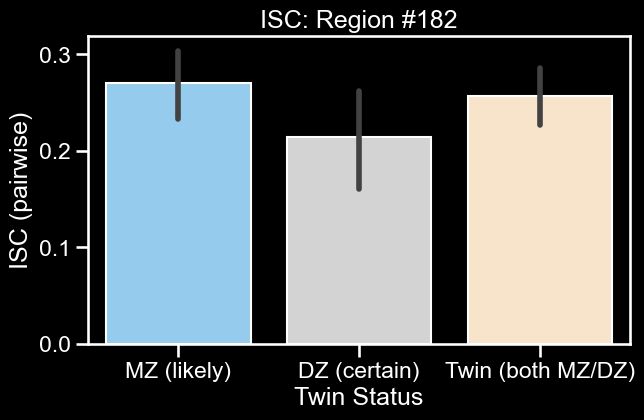

In [41]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

current_region_index = 182
#293 is anatomical_similarity


df0 = pd.DataFrame(np.vstack(( iscs_reg_cdz_twin[current_region_index,:], 
                   len(iscs_reg_cdz_twin[current_region_index,:]) * ['DZ (certain)'] )).T, 
                  columns = ['ISC','Twin Status'])

df1 = pd.DataFrame(np.vstack(( iscs_reg_lmz_twin[current_region_index,:], 
                   len(iscs_reg_lmz_twin[current_region_index,:]) * ['MZ (likely)'] )).T, 
                   columns = ['ISC','Twin Status'])

df2 = pd.DataFrame(np.vstack(( iscs_reg_twin[current_region_index,:], 
                   len(iscs_reg_twin[current_region_index,:]) * ['Twin (both MZ/DZ)'] )).T, 
                   columns = ['ISC','Twin Status'])

result_df = pd.concat([df1, df0, df2])
del df1, df2, df0


result_df['ISC'] = result_df['ISC'].astype('float')

#result_df = pd.read_csv('../data/05_results/twin_isc_df.csv')


plt.figure(figsize =  (7,4))
sns.barplot(data=result_df, 
            x="Twin Status", 
            y="ISC",
            palette = [ 'lightskyblue','lightgrey','bisque']).set(title='ISC: Region #' + str(current_region_index));
#plt.ylim([0., 0.45])
plt.ylabel('ISC (pairwise)');

In [13]:
#result_df.to_csv('../data/05_results/twin_isc_df.csv')

<Axes: >

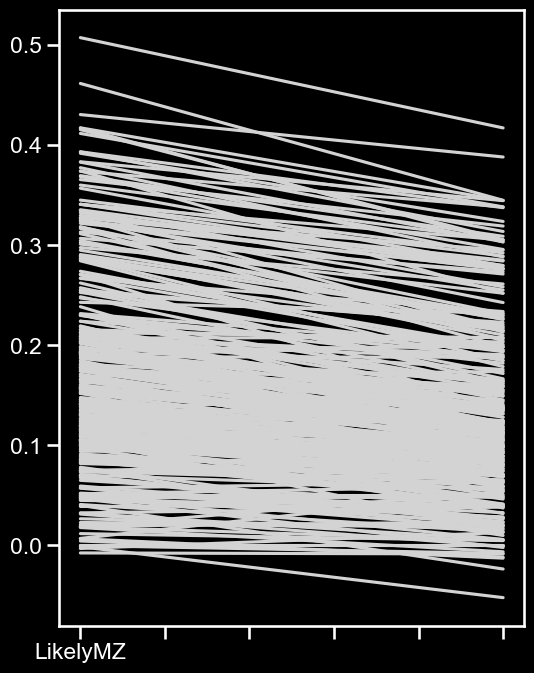

In [52]:
iscs_reg_twin.mean(axis = 1)
df = pd.DataFrame({'LikelyMZ': iscs_reg_lmz_twin.mean(axis = 1), 
                   'CertainlyDZ': iscs_reg_cdz_twin.mean(axis = 1)})
df.sort_values(by='LikelyMZ').T.plot(legend = False, color = 'lightgray', figsize = (6,8))